In [2]:
import pickle, os
from pathlib import Path
import hashlib
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
rq3_df = pd.read_csv('processed01_par10-20.csv')

In [4]:
rq3_df = rq3_df[rq3_df['speech_clean'].notnull()]
rq3_df = rq3_df[rq3_df['speech_clean'].str.split().str.len() > 50]

In [5]:
gov_df = rq3_df[rq3_df['is_government'] == 1]

<b style="color:red;">Checkpoint-Saved</b>

In [12]:
gov_df.to_csv('processed0rq3_par10-20.csv',index=False)

In [ ]:
gov_df = pd.read_csv('processed0rq3_par10-20.csv')

In [13]:
gov_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44997 entries, 13 to 316444
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   member_name       44997 non-null  object
 1   sitting_date      44997 non-null  object
 2   political_party   44997 non-null  object
 3   government        44997 non-null  object
 4   roles             44997 non-null  object
 5   member_gender     44997 non-null  object
 6   speech            44997 non-null  object
 7   year              44997 non-null  int64 
 8   is_government     44997 non-null  int64 
 9   speaker_gov_role  21484 non-null  object
 10  leadership_role   1336 non-null   object
 11  speech_clean      44997 non-null  object
dtypes: int64(2), object(10)
memory usage: 4.5+ MB


In [14]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")
model = AutoModel.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")
model.eval()

pytorch_model.bin:   0%|          | 0.00/454M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(35000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

model.safetensors:   0%|          | 0.00/454M [00:00<?, ?B/s]

<b style="color:blue;">Test to Sample - Started</b>

In [15]:
text = "ο πρωθυπουργός μίλησε για την οικονομική κρίση."

In [16]:
inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)

In [17]:
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print("Tokens:")
print(tokens)

Tokens:
['[CLS]', 'ο', 'πρωθυπουργος', 'μιλησε', 'για', 'την', 'οικονομικη', 'κριση', '.', '[SEP]']


In [18]:
with torch.no_grad():
    outputs = model(**inputs)

In [19]:
cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: (1, 768)
print("\nCLS embedding shape:", cls_embedding.shape)


CLS embedding shape: torch.Size([1, 768])


In [20]:
cls_vector = cls_embedding.squeeze().numpy()
print("First 10 values of CLS vector:\n", cls_vector[:10])

First 10 values of CLS vector:
 [-0.541107   -1.03107     0.6592555  -0.23075694 -0.03192329  0.46468037
  1.1373037   1.7603762  -0.868423   -0.55767894]


<b style="color:blue;">Test to Sample - END</b>

In [25]:
#Speech Embedding Function

def get_embedding(text, tokenizer, model, device='cpu'):
    # Tokenize the input text and return PyTorch tensors
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    # Move inputs to the device (e.g., CPU or CUDA/GPU)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    # Disable gradient tracking (for efficiency)
    with torch.no_grad():
        outputs = model(**inputs)
    # Get the [CLS] token embedding (first token)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: [1, 768]
    # Convert from PyTorch tensor to NumPy array
    return cls_embedding.squeeze().cpu().numpy()

<b style="color:blue;">Test to Sample - Started</b>

In [23]:
vec = get_embedding("ο πρωθυπουργός μίλησε για την οικονομική κρίση.", tokenizer, model)
print("Embedding shape:", vec.shape)
print("First 5 values:", vec[:5])

Embedding shape: (768,)
First 5 values: [-0.541107   -1.03107     0.6592555  -0.23075694 -0.03192329]


<b style="color:blue;">Test to Sample - Started</b>

In [26]:
year_embeddings = {}  # Will store: year → 768-dim vector

In [27]:
for year, group in gov_df.groupby("year"):
    print(f"Processing year {year} with {len(group)} speeches...")

    embeddings = []

    for speech in tqdm(group["speech_clean"], desc=f"Year {year}"):
        try:
            vec = get_embedding(speech, tokenizer, model)
            embeddings.append(vec)
        except Exception as e:
            continue  # Skip any speech that causes an error

    if embeddings:
        year_embeddings[year] = np.mean(embeddings, axis=0)

Processing year 2010 with 5101 speeches...


Year 2010:   0%|          | 0/5101 [00:00<?, ?it/s]

Processing year 2011 with 6427 speeches...


Year 2011:   0%|          | 0/6427 [00:00<?, ?it/s]

Processing year 2012 with 5121 speeches...


Year 2012:   0%|          | 0/5121 [00:00<?, ?it/s]

Processing year 2013 with 5108 speeches...


Year 2013:   0%|          | 0/5108 [00:00<?, ?it/s]

Processing year 2014 with 5035 speeches...


Year 2014:   0%|          | 0/5035 [00:00<?, ?it/s]

Processing year 2015 with 4267 speeches...


Year 2015:   0%|          | 0/4267 [00:00<?, ?it/s]

Processing year 2016 with 4884 speeches...


Year 2016:   0%|          | 0/4884 [00:00<?, ?it/s]

Processing year 2017 with 3960 speeches...


Year 2017:   0%|          | 0/3960 [00:00<?, ?it/s]

Processing year 2018 with 3463 speeches...


Year 2018:   0%|          | 0/3463 [00:00<?, ?it/s]

Processing year 2019 with 1631 speeches...


Year 2019:   0%|          | 0/1631 [00:00<?, ?it/s]

In [31]:
print("Raw years:", sorted(rq3_df['year'].unique()))
print(rq3_df['year'].value_counts().sort_index().tail(3)) 

Raw years: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
year
2018    8324
2019    9224
2020    6749
Name: count, dtype: int64


In [32]:
tmp = rq3_df[rq3_df['is_government'] == 1]
print("Gov years:", sorted(tmp['year'].unique()))
print(tmp['year'].value_counts().sort_index().tail(3))

Gov years: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
year
2017    3960
2018    3463
2019    1631
Name: count, dtype: int64


In [33]:
tmp = tmp[tmp['speech_clean'].notnull()]
print("Gov + notnull:", sorted(tmp['year'].unique()))
print(tmp['year'].value_counts().sort_index().tail(3))

Gov + notnull: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
year
2017    3960
2018    3463
2019    1631
Name: count, dtype: int64


In [34]:
tmp = tmp[tmp['speech_clean'].str.split().str.len() > 50]
print("Gov + notnull + >50 tokens:", sorted(tmp['year'].unique()))
print(tmp['year'].value_counts().sort_index().tail(3))

Gov + notnull + >50 tokens: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
year
2017    3960
2018    3463
2019    1631
Name: count, dtype: int64


<b style="color:red;">Checkpoint-Saved</b>

In [35]:
import pickle, os
from pathlib import Path

In [36]:
Path("embeddings").mkdir(exist_ok=True)

with open("embeddings/year_embeddings_gov.pkl", "wb") as f:
    pickle.dump(year_embeddings, f)

years_sorted = sorted(year_embeddings)
matrix = np.vstack([year_embeddings[y] for y in years_sorted])
np.savez_compressed("embeddings/year_embeddings_gov.npz",
                    years=np.array(years_sorted), vectors=matrix)

print("Saved to: embeddings/year_embeddings_gov.pkl and .npz")

Saved to: embeddings/year_embeddings_gov.pkl and .npz


In [37]:
import hashlib

In [40]:
# --- tiny per-speech cache ---
CACHE_DIR = "embeddings/speech_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

def embed_with_cache(text):
    key = hashlib.md5(text.encode("utf-8")).hexdigest()
    path = os.path.join(CACHE_DIR, f"{key}.npy")
    if os.path.exists(path):
        return np.load(path)
    vec = get_embedding(text, tokenizer, model)
    np.save(path, vec)
    return vec

# --- select 2020 speeches (ALL, not just gov) ---
g20 = rq3_df[(rq3_df["year"] == 2020) & rq3_df["speech_clean"].notnull()].copy()

# use a gentler length filter to avoid dropping many 2020 speeches
g20 = g20[g20["speech_clean"].str.split().str.len() > 20]

print("2020 speeches to embed:", len(g20))

# --- compute 2020 average embedding ---
embeds_2020 = [embed_with_cache(s) for s in tqdm(g20["speech_clean"], desc="Year 2020 (ALL speeches)")]
if embeds_2020:
    year_embeddings[2020] = np.mean(embeds_2020, axis=0)
    print("2020 vector shape:", year_embeddings[2020].shape)
else:
    print("No embeddings collected for 2020.")

2020 speeches to embed: 6749


Year 2020 (ALL speeches):   0%|          | 0/6749 [00:00<?, ?it/s]

2020 vector shape: (768,)


In [41]:
with open("embeddings/year_embeddings_gov.pkl", "wb") as f:
    pickle.dump(year_embeddings, f)

years_sorted = sorted(year_embeddings)
matrix = np.vstack([year_embeddings[y] for y in years_sorted])
np.savez_compressed("embeddings/year_embeddings_gov.npz",
                    years=np.array(years_sorted), vectors=matrix)

print("Years embedded:", years_sorted)
print("Example vector shape:", year_embeddings[years_sorted[0]].shape)

Years embedded: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Example vector shape: (768,)


In [ ]:
npz_path = Path("embeddings/year_embeddings_gov.npz")
pkl_path = Path("embeddings/year_embeddings_gov.pkl")

if npz_path.exists():
    npz = np.load(npz_path, allow_pickle=True)
    years_sorted = npz["years"].astype(int)
    matrix = npz["vectors"]  # shape: (n_years, 768)
    # Also reconstruct dict (handy later)
    year_embeddings = {int(y): vec for y, vec in zip(years_sorted, matrix)}
else:
    # Fallback: load the pickle dict
    with open(pkl_path, "rb") as f:
        year_embeddings = pickle.load(f)
    years_sorted = np.array(sorted(year_embeddings))
    matrix = np.vstack([year_embeddings[int(y)] for y in years_sorted])

print("Years:", years_sorted.tolist())
print("Matrix shape:", matrix.shape)  # (n_years, 768)

In [43]:
from sklearn.metrics.pairwise import cosine_similarity

In [44]:
# Cosine similarity between all years (n_years x n_years)
cos_sim = cosine_similarity(matrix)
# Convert to distances (0 = identical, larger = more different)
cos_dist = 1 - cos_sim

# Put in a labeled DataFrame (handy to inspect or export)
dist_df = pd.DataFrame(cos_dist, index=years_sorted, columns=years_sorted)

# Year-over-year distance (how much each year moves from the previous one)
yoy = []
for i in range(1, len(years_sorted)):
    prev_i = i - 1
    yoy.append({
        "year": int(years_sorted[i]),
        "from_year": int(years_sorted[prev_i]),
        "yoy_distance": float(cos_dist[i, prev_i])
    })
yoy_df = pd.DataFrame(yoy)

# Distance from the first year (cumulative drift)
baseline_year = int(years_sorted[0])
drift = []
for i in range(len(years_sorted)):
    drift.append({
        "year": int(years_sorted[i]),
        "from_year": baseline_year,
        "drift_distance": float(cos_dist[i, 0])
    })
drift_df = pd.DataFrame(drift)

# Save for your appendix
dist_df.to_csv("embeddings/year_pairwise_cosine_distance.csv", index=True)
yoy_df.to_csv("embeddings/year_yoy_distance.csv", index=False)
drift_df.to_csv("embeddings/year_drift_from_baseline.csv", index=False)

print("Saved: pairwise, YoY, and drift CSVs in /embeddings/")
yoy_df.head(), drift_df.head()

Saved: pairwise, YoY, and drift CSVs in /embeddings/


(   year  from_year  yoy_distance
 0  2011       2010      0.000489
 1  2012       2011      0.000630
 2  2013       2012      0.000352
 3  2014       2013      0.000586
 4  2015       2014      0.003977,
    year  from_year  drift_distance
 0  2010       2010    2.384186e-07
 1  2011       2010    4.888773e-04
 2  2012       2010    1.428723e-03
 3  2013       2010    2.079725e-03
 4  2014       2010    3.544688e-03)

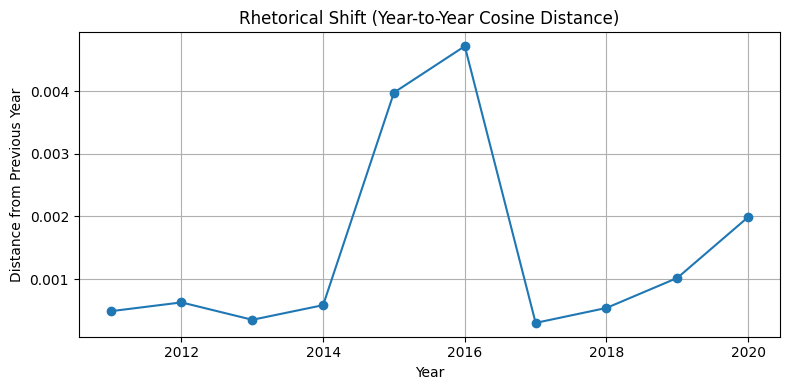

In [46]:
years_yoy = yoy_df["year"].values
vals_yoy = yoy_df["yoy_distance"].values

plt.figure(figsize=(8,4))
plt.plot(years_yoy, vals_yoy, marker="o")
plt.title("Rhetorical Shift (Year-to-Year Cosine Distance)")
plt.xlabel("Year")
plt.ylabel("Distance from Previous Year")
plt.grid(True)
plt.tight_layout()
plt.savefig("embeddings/plot_yoy_distance.png", dpi=200)
plt.show()

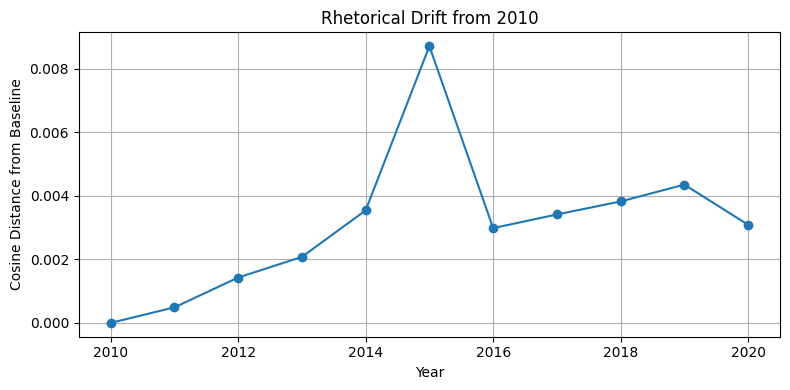

In [47]:
years_drift = drift_df["year"].values
vals_drift = drift_df["drift_distance"].values

plt.figure(figsize=(8,4))
plt.plot(years_drift, vals_drift, marker="o")
plt.title(f"Rhetorical Drift from {baseline_year}")
plt.xlabel("Year")
plt.ylabel("Cosine Distance from Baseline")
plt.grid(True)
plt.tight_layout()
plt.savefig("embeddings/plot_drift_from_baseline.png", dpi=200)
plt.show()

## 📊 Results & Visualizations

In [2]:
import plotly.express as px
import plotly.graph_objects as go

In [3]:
colors = px.colors.qualitative.Prism

In [23]:
prism = px.colors.qualitative.Prism

### RQ1: How do government and opposition parties differ in their emotional rhetoric during political crises?

In [7]:
rq1_rdf = pd.read_csv('RQ1_results_df.csv')

In [8]:
rq1_rdf = rq1_rdf.drop(columns=['Unnamed: 0'])

In [9]:
rq1_rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341805 entries, 0 to 341804
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   member_name      341805 non-null  object 
 1   political_party  341805 non-null  object 
 2   year             341805 non-null  int64  
 3   is_government    341805 non-null  int64  
 4   roles            341805 non-null  object 
 5   anger            341805 non-null  float64
 6   disgust          341805 non-null  float64
 7   fear             341805 non-null  float64
 8   happiness        341805 non-null  float64
 9   sadness          341805 non-null  float64
 10  surprise         341805 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 28.7+ MB


In [10]:
label_map = {1: "Government", 0: "Opposition"}
rq1_rdf["gov_label"] = rq1_rdf["is_government"].map(label_map)

In [11]:
emotions = ["anger", "disgust", "fear", "happiness", "sadness", "surprise"]

In [12]:
means = (
    rq1_rdf.groupby("gov_label")[emotions]
      .mean()
      .reset_index()
      .melt(id_vars="gov_label", var_name="emotion", value_name="mean_score")
)

sems = (
    rq1_rdf.groupby("gov_label")[emotions]
      .agg(lambda x: x.std(ddof=1) / np.sqrt(x.count()))
      .reset_index()
      .melt(id_vars="gov_label", var_name="emotion", value_name="sem")
)

plot_df = means.merge(sems, on=["gov_label", "emotion"])

In [13]:
plot_df["emotion"] = pd.Categorical(plot_df["emotion"], categories=emotions, ordered=True)


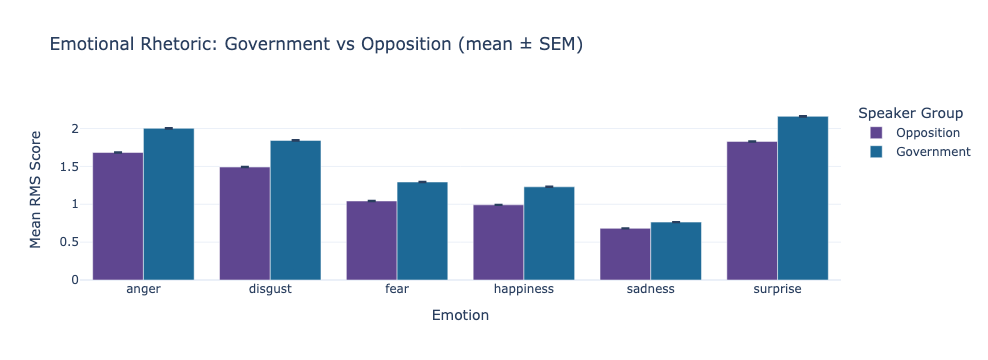

In [15]:
fig = px.bar(
    plot_df,
    x="emotion",
    y="mean_score",
    color="gov_label",
    barmode="group",
    error_y="sem",
    color_discrete_sequence=px.colors.qualitative.Prism,
    category_orders={"gov_label": plot_df["gov_label"].unique()[::-1]},  # reversed order
    labels={
        "emotion": "Emotion",
        "mean_score": "Mean RMS Score",
        "gov_label": "Group"
    },
    title="Emotional Rhetoric: Government vs Opposition (mean ± SEM)"
)

fig.update_layout(
    legend_title_text="Speaker Group",
    bargap=0.20,
    template="plotly_white",
)

# Optional: tidy y-range a bit
ymax = plot_df["mean_score"].max()
fig.update_yaxes(range=[0, ymax * 1.1])

fig.show()

In [17]:
long_df = rq1_rdf.melt(
    id_vars=["year", "gov_label"],
    value_vars=emotions,
    var_name="emotion",
    value_name="score"
)

In [18]:
agg = (
    long_df
    .groupby(["year", "gov_label", "emotion"], as_index=False)
    .agg(
        mean_score=("score", "mean"),
        sem=("score", lambda x: x.std(ddof=1) / np.sqrt(x.count()))
    )
)

In [19]:
agg["emotion"] = pd.Categorical(agg["emotion"], categories=emotions, ordered=True)

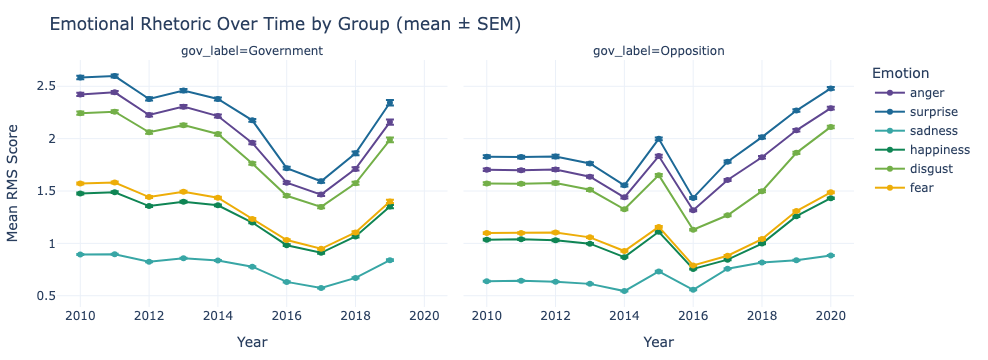

In [20]:
fig = px.line(
    agg.sort_values("year"),
    x="year",
    y="mean_score",
    color="emotion",
    line_group="emotion",
    facet_col="gov_label",
    facet_col_wrap=2,
    markers=True,
    error_y="sem",
    color_discrete_sequence=px.colors.qualitative.Prism,
    labels={
        "year": "Year",
        "mean_score": "Mean RMS Score",
        "emotion": "Emotion"
    },
    title="Emotional Rhetoric Over Time by Group (mean ± SEM)"
)

fig.update_layout(
    template="plotly_white",
    legend_title_text="Emotion",
    margin=dict(l=40, r=20, t=60, b=40),
)

# Make x-axes show integer ticks and share Y across facets
for ax in fig.layout:
    if isinstance(fig.layout[ax], dict) and ax.startswith("xaxis"):
        fig.layout[ax].tickmode = "linear"

fig.update_yaxes(matches="y")  # same y-scale across facets
fig.show()

### RQ2: Do political elites (Prime Minister and Ministers) use more complex or simplified language compared to other MPs?

In [36]:
rq2_rdf = pd.read_csv('RQ2_results_df.csv')

In [41]:
rq2_rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341805 entries, 0 to 341804
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   member_name       341805 non-null  object 
 1   year              341805 non-null  int64  
 2   political_party   341805 non-null  object 
 3   is_government     341805 non-null  int64  
 4   speaker_gov_role  60473 non-null   object 
 5   leadership_role   10689 non-null   object 
 6   roles             341805 non-null  object 
 7   smog_score        8347 non-null    float64
dtypes: float64(1), int64(2), object(5)
memory usage: 20.9+ MB


In [104]:
# 1. Drop null SMOG scores
valid_smog = rq2_rdf[rq2_rdf['smog_score'].notna()]

# 2. Group by speaker and compute average SMOG score
speaker_avg_smog = valid_smog.groupby(
    ['member_name', 'political_party']
)['smog_score'].mean().reset_index()

# 3. Sort and get top 5 and bottom 5
top5 = speaker_avg_smog.sort_values(by='smog_score', ascending=False).head(5)
bottom5 = speaker_avg_smog.sort_values(by='smog_score', ascending=True).head(5)

# 4. Combine results
extremes = pd.concat([top5, bottom5]).reset_index(drop=True)

In [64]:
yearly_avg_smog = rq2_rdf[rq2_rdf['smog_score'].notna()] \
    .groupby(['year', 'is_government'])['smog_score'] \
    .mean() \
    .reset_index()

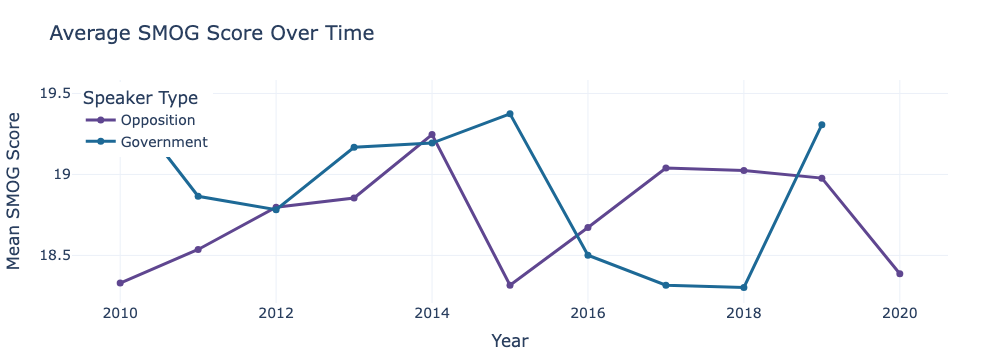

In [77]:
fig = go.Figure()

for i, (label, group) in enumerate(yearly_avg_smog.groupby('is_government')):
    name = 'Government' if label == 1 else 'Opposition'
    fig.add_trace(go.Scatter(
        x=group['year'],
        y=group['smog_score'],
        mode='lines+markers',
        name=name,
        line=dict(width=3, color=colors[i]),
        marker=dict(size=7, color=colors[i])
    ))

# Layout styling with Plotly + Prisma aesthetic
fig.update_layout(
    title="Average SMOG Score Over Time",
    xaxis_title="Year",
    yaxis_title="Mean SMOG Score",
    template="plotly_white",
    legend=dict(title="Speaker Type", x=0.01, y=0.99),
    hovermode="x unified",
    font=dict(size=14),
    margin=dict(l=40, r=40, t=80, b=40)
)

fig.show()

In [68]:
speech_counts = rq2_rdf[rq2_rdf['smog_score'].notna()] \
    .groupby(['year', 'is_government'])['smog_score'] \
    .count() \
    .reset_index() \
    .rename(columns={'smog_score': 'speech_count'})

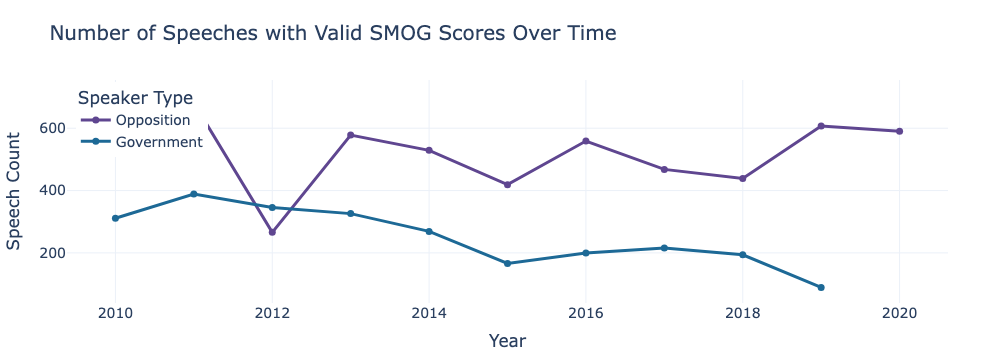

In [79]:
# Build interactive line chart for speech count
fig = go.Figure()

for i, (label, group) in enumerate(speech_counts.groupby('is_government')):
    name = 'Government' if label == 1 else 'Opposition'
    fig.add_trace(go.Scatter(
        x=group['year'],
        y=group['speech_count'],
        mode='lines+markers',
        name=name,
        line=dict(width=3, color=colors[i]),
        marker=dict(size=7, color=colors[i])
    ))

# Apply layout and Prisma-friendly styling
fig.update_layout(
    title="Number of Speeches with Valid SMOG Scores Over Time",
    xaxis_title="Year",
    yaxis_title="Speech Count",
    template="plotly_white",
    legend=dict(title="Speaker Type", x=0.01, y=0.99),
    hovermode="x unified",
    font=dict(size=14),
    margin=dict(l=40, r=40, t=80, b=40)
)

fig.show()

In [53]:
valid_smog = rq2_rdf[rq2_rdf['smog_score'].notna()]

In [82]:
from plotly.subplots import make_subplots

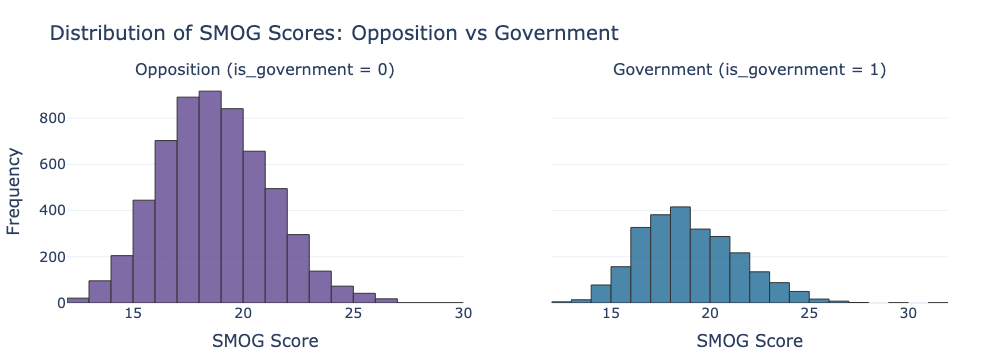

In [85]:
# Filter valid scores
valid_smog = rq2_rdf[rq2_rdf['smog_score'].notna()]
gov_scores = valid_smog[valid_smog['is_government'] == 1]['smog_score']
opp_scores = valid_smog[valid_smog['is_government'] == 0]['smog_score']

# Create side-by-side subplot layout
fig = make_subplots(
    rows=1, cols=2,
    shared_yaxes=True,
    subplot_titles=("Opposition (is_government = 0)", "Government (is_government = 1)")
)

# Add Opposition histogram
fig.add_trace(go.Histogram(
    x=opp_scores,
    nbinsx=30,
    name='Opposition',
    marker=dict(color=colors[0], line=dict(width=1, color='black')),
    opacity=0.8,
    showlegend=False
), row=1, col=1)

# Add Government histogram
fig.add_trace(go.Histogram(
    x=gov_scores,
    nbinsx=30,
    name='Government',
    marker=dict(color=colors[1], line=dict(width=1, color='black')),
    opacity=0.8,
    showlegend=False
), row=1, col=2)

# Update layout
fig.update_layout(
    title="Distribution of SMOG Scores: Opposition vs Government",
    template="plotly_white",
    font=dict(size=14),
    margin=dict(l=40, r=40, t=80, b=40),
    xaxis_title="SMOG Score",
    xaxis2_title="SMOG Score",
    yaxis_title="Frequency"
)

fig.show()

In [55]:
from scipy.stats import ttest_ind

gov_scores = valid_smog[valid_smog['is_government'] == 1]['smog_score']
opp_scores = valid_smog[valid_smog['is_government'] == 0]['smog_score']

t_stat, p_value = ttest_ind(gov_scores, opp_scores, equal_var=False)  # Welch’s t-test

print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")

T-statistic: 3.572, p-value: 0.0004


In [56]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(gov_scores, opp_scores, alternative='two-sided')

print(f"U-statistic: {u_stat:.3f}, p-value: {p_value:.4f}")

U-statistic: 7600343.500, p-value: 0.0053


In [107]:
from numpy import mean, std
from math import sqrt

d = (mean(gov_scores) - mean(opp_scores)) / sqrt((std(gov_scores)**2 + std(opp_scores)**2) / 2)
print("Cohen's d:", round(d, 3))

Cohen's d: 0.085


### RQ3: Has the government’s rhetorical style shifted over time? (Greek BERT)

In [17]:
# Read the pairwise cosine distance matrix
dist_df = pd.read_csv("embeddings/year_pairwise_cosine_distance.csv", index_col=0)

# Read the year-over-year distances
yoy_df = pd.read_csv("embeddings/year_yoy_distance.csv")

# Read the drift-from-baseline distances
drift_df = pd.read_csv("embeddings/year_drift_from_baseline.csv")

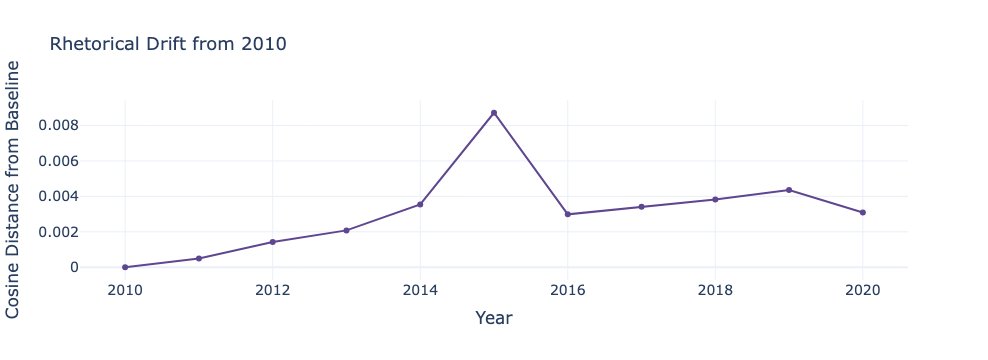

In [22]:
fig_drift = px.line(
    drift_df, 
    x="year", 
    y="drift_distance", 
    markers=True, 
    title=f"Rhetorical Drift from {drift_df['from_year'].iloc[0]}",
    color_discrete_sequence=colors
)

fig_drift.update_layout(
    template="plotly_white",
    xaxis_title="Year",
    yaxis_title="Cosine Distance from Baseline",
    title_font_size=18,
    font=dict(size=14),
    plot_bgcolor="white"
)

fig_drift.show()

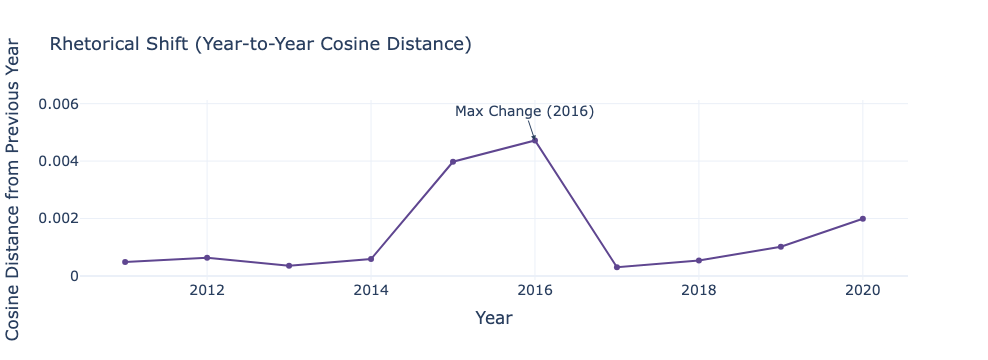

In [23]:
# Create figure
fig_yoy = px.line(
    yoy_df, 
    x="year", 
    y="yoy_distance", 
    markers=True, 
    title="Rhetorical Shift (Year-to-Year Cosine Distance)",
    color_discrete_sequence=colors
)

# Find max change year/value
max_year = yoy_df.loc[yoy_df["yoy_distance"].idxmax(), "year"]
max_val = yoy_df["yoy_distance"].max()

# Add annotation
fig_yoy.add_annotation(
    x=max_year,
    y=max_val,
    text=f"Max Change ({max_year})",
    showarrow=True,
    arrowhead=2
)

# Layout polish
fig_yoy.update_layout(
    template="plotly_white",
    xaxis_title="Year",
    yaxis_title="Cosine Distance from Previous Year",
    title_font_size=18,
    font=dict(size=14),
    plot_bgcolor="white"
)

fig_yoy.show()